In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
#%run ../../core/resolution.py
# gather all ingredients and save them as unified 'mephistogram' data structure
#%run ../../core/prepare_histograms.py

In [3]:
import mkl
mkl.set_num_threads(1)

48

In [4]:
import numpy as np
from glob import glob
from tools import ang_dist

import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join
from scipy.interpolate import InterpolatedUnivariateSpline

import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    PL_flux,
    PLcut_flux,
    ngc_flux,
    ngc_cut_flux
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from tools import array_source_interp
from likelihood import poisson_llh
import settings as st
from astropy.time import Time
from scipy.stats import poisson
from astropy.coordinates import SkyCoord

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [5]:
cur_cmap = st.ecap_cmap

# Real data

In [6]:
# full 10yr data release
all_data = []
for fn in glob(join(st.LOCALPATH, "icecube_10year_ps/events/IC*.csv")):
    all_data.extend(np.genfromtxt(fn, names=True))
all_data = np.array(all_data)


if False: 
    exp_data = all_data
    # Full livetime
    LIVETIME = st.LIVETIME 
else:
    # we take only the full detector configurations >= IC86-II,
    # because these we also took for the resolutions and effective area
    exp_data = []
    for fn in sorted(glob(join(st.LOCALPATH, "icecube_10year_ps/events/IC86*.csv"))):
        if "_I_" in fn: continue
        print(fn)
        exp_data.extend(np.genfromtxt(fn, names=True))
    exp_data = np.array(exp_data)
    # Overwrite 10yr livetime with only IC86-II and later
    LIVETIME = st.LIVETIME_86



/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_III_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_II_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_IV_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_VII_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_VI_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_V_exp.csv


## plots

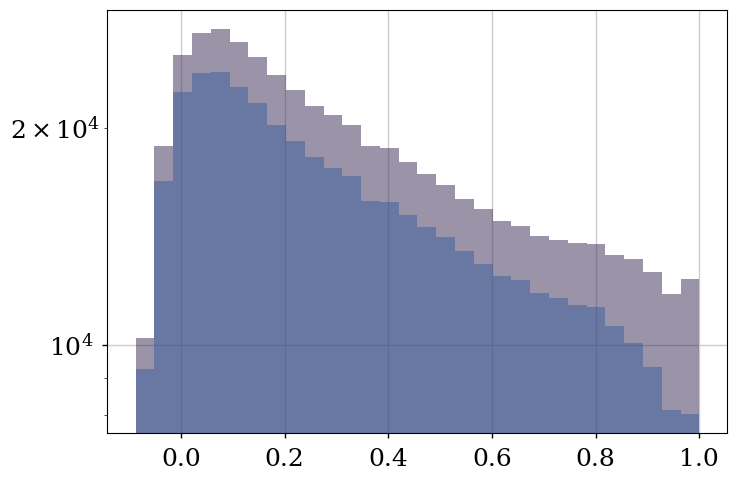

In [7]:
plt.figure()
_ = plt.hist(
    np.sin(np.deg2rad(exp_data["Decdeg"][(exp_data["Decdeg"] >= -5)])),
    bins=30,
    alpha=0.5,
)  # st.sindec_bins)
_ = plt.hist(
    np.sin(
        np.deg2rad(
            exp_data["Decdeg"][
                (exp_data["Decdeg"] >= -5) & (exp_data["log10EGeV"] >= 2.8)
            ]
        )
    ),
    bins=30,
    alpha=0.5,
)  # st.sindec_bins)
plt.yscale("log")

## calculate angular distances

In [8]:
angular_distances = np.rad2deg(
    ang_dist(
        st.ngc1068.ra.rad,
        st.ngc1068.dec.rad,
        np.deg2rad(exp_data["RAdeg"]),
        np.deg2rad(exp_data["Decdeg"]),
    )
)[0]


# select events within the analysis window
ngc_dist_mask = angular_distances <= st.delta_psi_max
ngc_events = exp_data[ngc_dist_mask]
ngc_angular_distances = angular_distances[ngc_dist_mask]

# select events in declination band
dec_distances = np.rad2deg(
    ang_dist(
        0,
        st.ngc1068.dec.rad,
        np.zeros_like(exp_data["RAdeg"]),
        np.deg2rad(exp_data["Decdeg"]),
    )
)[0]

ngc_dec_mask = ~ngc_dist_mask & (
    dec_distances <= st.delta_psi_max
)  # remove events close to ngc1068, but keep those in similar declination
ngc_dec_events = exp_data[ngc_dec_mask]
ngc_dec_distances = dec_distances[ngc_dec_mask]

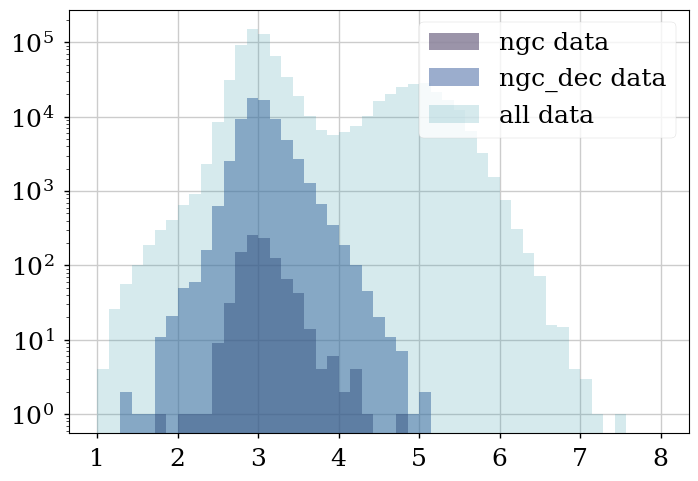

In [9]:
bins = np.linspace(1, 8, num=50)
plt.hist(ngc_events["log10EGeV"], bins=bins, alpha=0.5, label="ngc data")
plt.hist(ngc_dec_events["log10EGeV"], bins=bins, alpha=0.5, label="ngc_dec data")
plt.hist(exp_data["log10EGeV"], bins=bins, alpha=0.2, label="all data")
plt.yscale("log")
plt.legend(loc=0)

Text(0, 0.5, 'dec/deg')

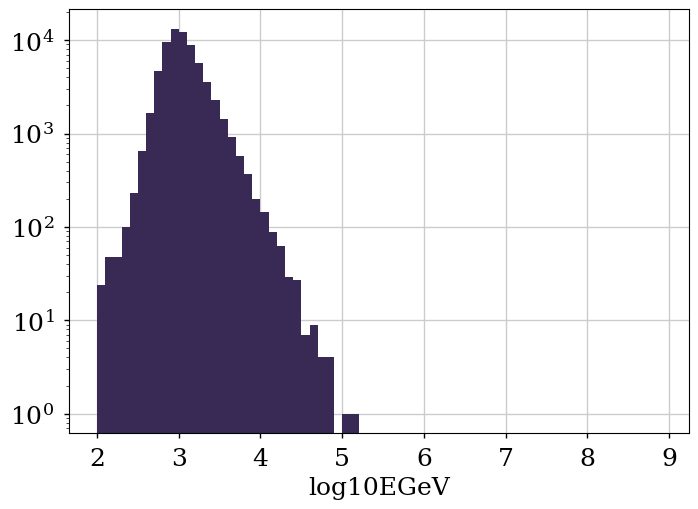

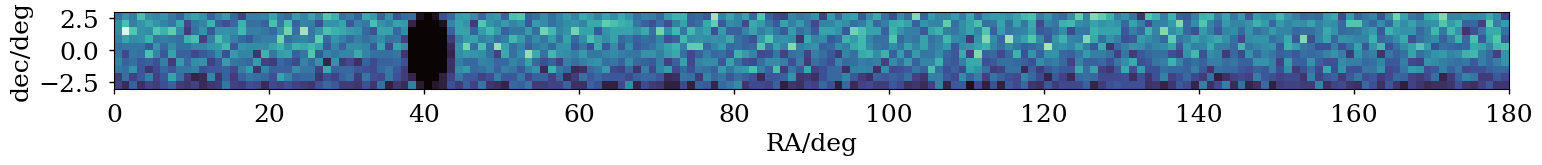

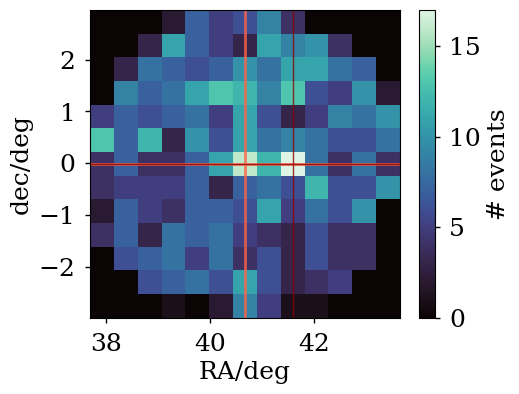

In [10]:
plt.figure()
plt.hist(ngc_dec_events["log10EGeV"], bins=st.logE_reco_bins[::2])
plt.yscale("log")
plt.xlabel("log10EGeV")

plt.figure(figsize=(18, 1))
_ = plt.hist2d(ngc_dec_events["RAdeg"], ngc_dec_events["Decdeg"], bins=(360, 10))
plt.xlabel("RA/deg")
plt.ylabel("dec/deg")
plt.xlim(0, 180)

plt.figure(figsize=(5, 4))
h, edx, edy, im = plt.hist2d(ngc_events["RAdeg"], ngc_events["Decdeg"], bins=13)
plt.colorbar(label="# events")
midx = st.get_mids(edx)
midy = st.get_mids(edy)
idx = np.argmax(h)
new_hot = SkyCoord(
    dec=midy[idx % len(midy)], ra=midx[idx // len(midx)], frame="icrs", unit="deg"
)
plt.scatter(
    st.ngc1068.ra.deg, st.ngc1068.dec.deg, color="tomato", marker="+", s=1e5, alpha=0.8
)
plt.scatter(
    new_hot.ra.deg,
    new_hot.dec.deg,
    color="darkred",
    lw=1,
    marker="+",
    s=1e5,
    alpha=0.8,
)
plt.xlabel("RA/deg")
plt.ylabel("dec/deg")

In [11]:
st.ngc1068, new_hot

(<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (40.667, -0.0069)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (41.58988462, -0.012)>)

## ngc1068 2022 data release


In [12]:
new_ev = pd.read_csv(join(st.LOCALPATH, "ps_data_release/resources/event_list.txt"))

(35.0, 45.0)

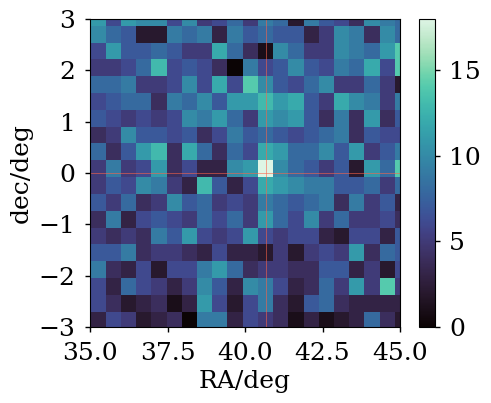

In [13]:
plt.figure(figsize=(5, 4))
h, edx, edy, im = plt.hist2d(np.rad2deg(new_ev["ra"]), np.rad2deg(new_ev["dec"]), bins=61)
plt.colorbar()
plt.scatter(
    st.ngc1068.ra.deg, st.ngc1068.dec.deg, color="tomato", marker="+", s=1e6, alpha=0.8, lw=0.5
)
plt.xlabel("RA/deg")
plt.ylabel("dec/deg")
plt.ylim(-3, 3)
plt.xlim(35, 45)

## Timeline

In [14]:
start_2022_data = Time("2011-05-13").decimalyear
start_plenum_data = Time(exp_data["MJDdays"].min(), format="mjd").decimalyear
start_all_data = Time(all_data["MJDdays"].min(), format="mjd").decimalyear
end_plenum_data = Time(exp_data["MJDdays"].max(), format="mjd").decimalyear
end_all_data = Time(all_data["MJDdays"].max(), format="mjd").decimalyear
end_2022_data = Time("2020-05-29").decimalyear


In [15]:
collect_times = {
    "PLEnuM data": {
        "data": [start_plenum_data.view(), end_plenum_data.view()],
        "plotting_kw": {"marker": "*", "ls": "-", "color": "tomato", "ms": 15},
    },
    "IceCube NGC 1068 (2022)": {
        "data": [start_2022_data.view(), end_2022_data.view()],
        "plotting_kw": {"marker": "s", "ls": "--", "color": "k", "ms": 10},
    },
    "IceCube NGC 1068 (2020)": {
        "data": [start_all_data.view(), end_all_data.view()],
        "plotting_kw": {"marker": "o", "ls": ":", "color": "k", "ms": 10},
    },
}
for k in collect_times:
    print(collect_times[k]["data"])

[2012.318105689836, 2018.517733159589]
[2011.3616438356164, 2020.4071038251366]
[2008.2633309090984, 2018.517733159589]


For the sake of simplicity, we use the effective area and resolution functions of only IC86. Further updates will see the "per detector config" PDFs. Much of the discrepancy is mitigated by using data itself to describe the background PDF of reconstructed energy.

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [16]:
with open(join(st.LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

# Atmospheric background

In [17]:
with open(join(st.LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [18]:
with open(join(st.LOCALPATH, "GP_Eres_mephistograms.pckl"), "rb") as f: #
    all_eres = pickle.load(f)
# select only horizontal resolution for NGC 1068 at horizon
baseline_eres = all_eres['dec-0.0']
baseline_eres.normalize(axis=1) # normalize per logE_true


Text(0.5, 1.0, 'dec--50.0')

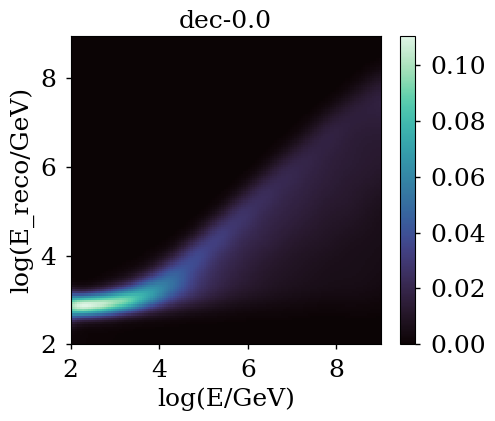

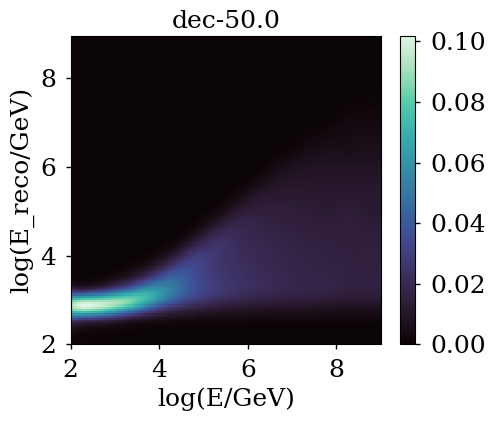

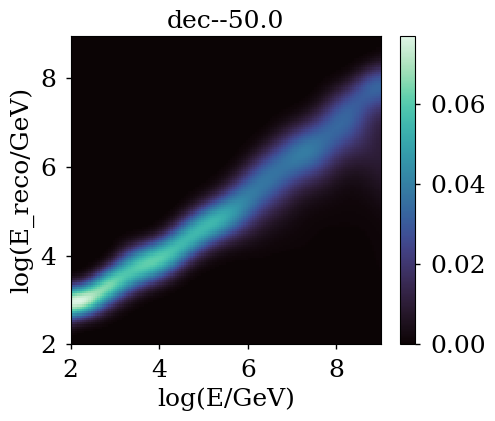

In [19]:
all_eres['dec-0.0'].plot()
plt.gca().set_title('dec-0.0')
all_eres['dec-50.0'].plot()
plt.gca().set_title('dec-50.0')
all_eres['dec--50.0'].plot()
plt.gca().set_title('dec--50.0')


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

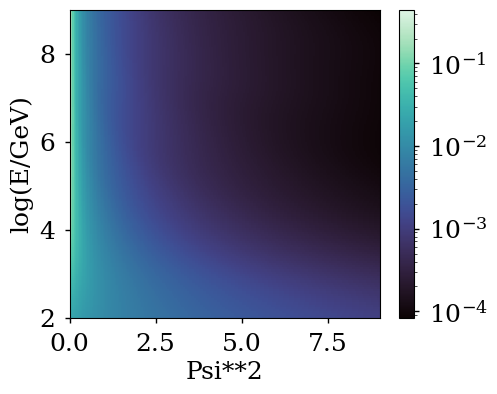

In [20]:
# angular resolution
with open(join(st.LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
# select only horizontal resolution for NGC 1068 at horizon
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

e_psi2_grid.plot(norm=LogNorm())

# event numbers 
## atmospheric neutrinos

In [21]:
from aeff_calculations import aeff_eval_e_sd


In [22]:
ident = "IceCube"
# check that the bins match
aeff_factor = aeff_eval_e_sd(aeff_2d[ident], st.sindec_width, st.ewidth, st.ra_width) * LIVETIME

atm_ev = aeff_factor * bckg_histo[ident] @ baseline_eres
print(np.sum(atm_ev))


464121.4622808845


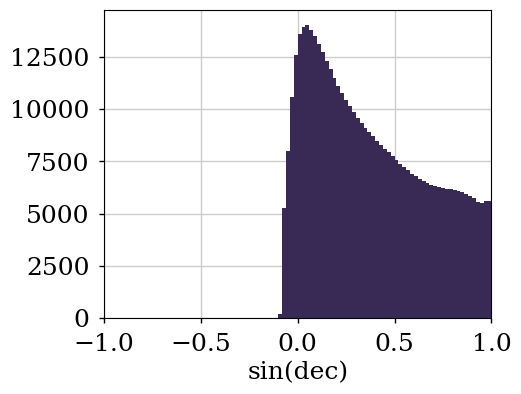

In [23]:
sdec_atm = atm_ev.sum(axis=1, return_mephisto=True)
sdec_atm.plot()

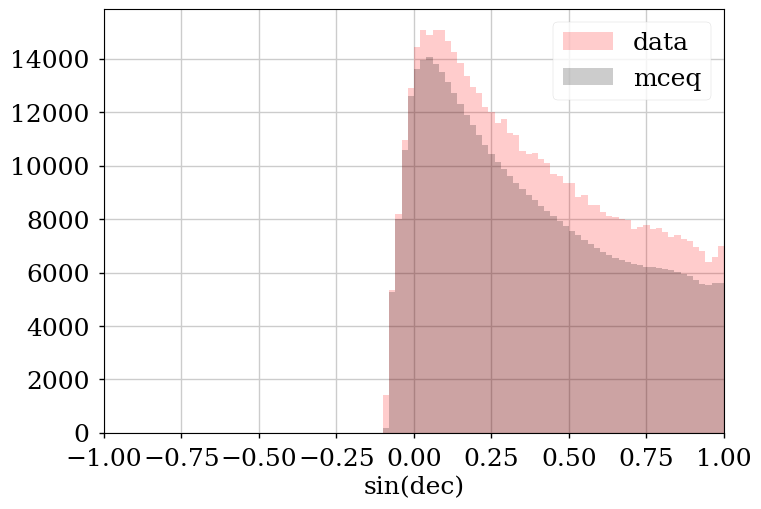

In [24]:
mask = exp_data['Decdeg'] > -5
f, ax = plt.subplots()
ax.hist(np.sin(np.deg2rad(exp_data['Decdeg'][mask])), bins=sdec_atm.bins, alpha=0.2, label="data", color="red")
sdec_atm.plot(f=f, ax=ax, alpha=0.2, label="mceq", color="k")
plt.legend()

In [25]:
logE_atm = atm_ev.sum(axis=0, return_mephisto=True)

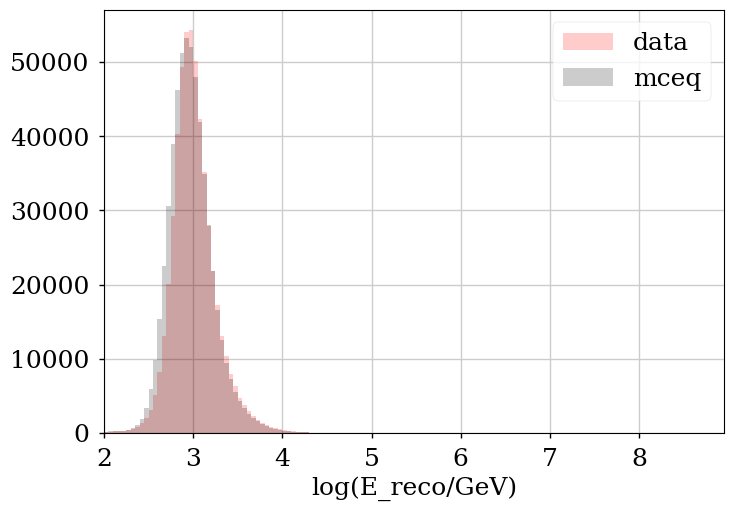

In [26]:
mask = exp_data['Decdeg'] > -5
f, ax = plt.subplots()
ax.hist(exp_data['log10EGeV'][mask], bins=logE_atm.bins, alpha=0.2, label="data", color="red")
(logE_atm*1.25).plot(f=f, ax=ax, alpha=0.2, label="mceq", color="k")
plt.legend()

# Flux definition

In [27]:
from fluxes import flux_collection, ngc_flux, ngc_cut_flux

In [28]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(st.LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11

# 10yr PS paper (data release)
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(join(st.LOCALPATH, "tenyr_paper_68_contour.txt"))
phi_c_68_prev *= 1E-3



In [29]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad



# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [30]:
from likelihood import ps_llh_multi, ps_llh_single, setup_multi_llh
from fluxes import astro_flux


# Asimov data

In [31]:
# reduced livetime!
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_e,
    ) = setup_multi_llh(
        eres=baseline_eres,
        conf=conf,
        aeff_2d=aeff_2d,
        src_flux=ngc_flux,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_e,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.1, 1.1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.06721203]
Signal fit parameters: [1.00002    0.99960789 3.19975944]
TS check: -308015.5460787396 (fit:  -308015.5460776364 )
-2 Delta LLH: 13.720768867293373
P-VALUE: 0.001048510772318767 SIGNIFICANCE: 3.0761360250261585

Plenum-1
Atmo-only normalization: [1.09225419]
Signal fit parameters: [1.00012199 0.99973149 3.19974617]
TS check: -1375928.7130636196 (fit:  -1375928.713032566 )
-2 Delta LLH: 77.91057236795314
P-VALUE: 1.2076307677112905e-17 SIGNIFICANCE: 8.471849940342876

Plenum-2
Atmo-only normalization: [1.07525521]
Signal fit parameters: [1.00004834 0.99969905 3.1998379 ]
TS check: -1333931.8895838927 (fit:  -1333931.8895684485 )
-2 Delta LLH: 168.1862827364821
P-VALUE: 3.0117071351931294e-37 SIGNIFICANCE: 12.698551633335441



# real data
## plotting

In [32]:
print(ngc_events["log10EGeV"].max())


4.73


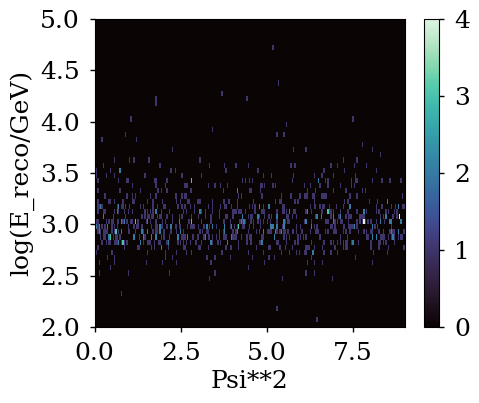

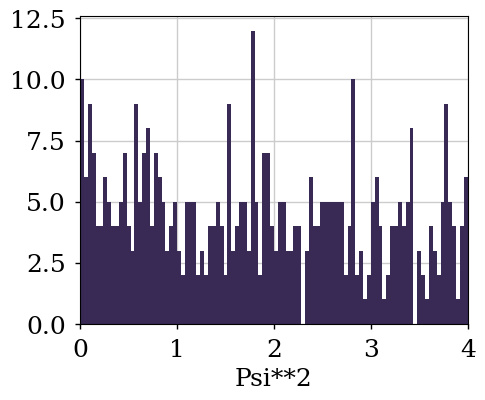

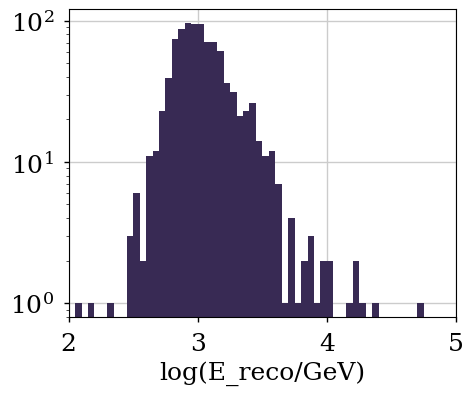

In [33]:
data_hist = mephisto.Mephistogram(
    (ngc_angular_distances**2, ngc_events["log10EGeV"]),
    bins=all_k[0].bins,
    axis_names=all_k[0].axis_names,
    make_hist=True
)

data_hist.plot()
plt.ylim(2, 5)

data_hist.sum(axis=1, return_mephisto=True).plot()
plt.gca().set_xlim(0, 4)
data_hist.sum(axis=0, return_mephisto=True).plot()

plt.xlim(2, 5)
plt.gca().set_yscale("log")


(2.0, 5.0)

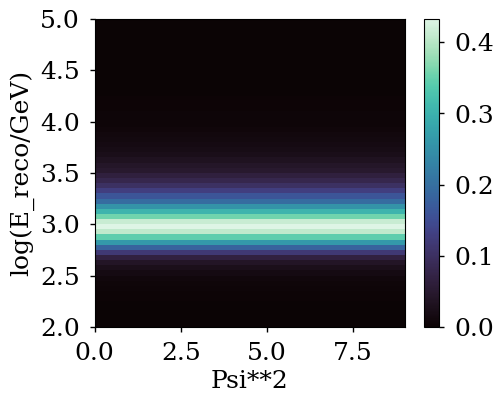

In [34]:
# make the background PDF from data
# use the energy distribution for one axis...
data_bg_hist, _ = np.histogram(ngc_dec_events["log10EGeV"], bins=st.logE_reco_bins)

# ... and a uniform distribution for the angular distance axis
data_bg = mephisto.Mephistogram(
    np.tile(data_bg_hist, len(st.psi2_mids)).reshape(data_hist.shape),
    bins=data_hist.bins,
    axis_names=data_hist.axis_names,
    make_hist=False,
)
# normalize such that it matches the data
# then the BG normalization will be close to 1 in the fit
data_bg.normalize(mode="full")
data_bg *= data_hist.sum()
data_bg.plot()
plt.ylim(2, 5)



In [35]:
bg_from_data = True

## analysis - point source

Atmo-only normalization: [0.99999996]
Signal fit parameters: [0.93189545 1.0826587  3.2733312 ]
Signal normalization:  5.413293475971548e-14
P-VALUE:3.48e-04 SIGNIFICANCE: 3.390885983197524


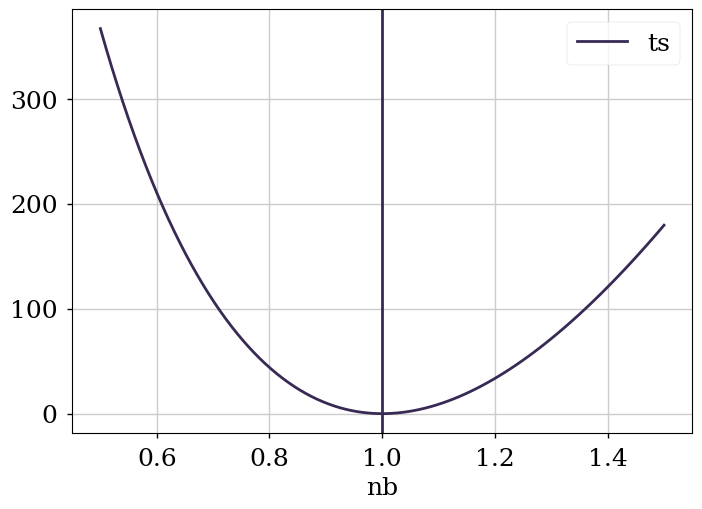

In [36]:
# ngc1068
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

dct = dict(
    shape="powerlaw",
    aeff_factor_b=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
)

bg_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)

out_bckg = fmin_l_bfgs_b(
    bg_llh,
    x0=(1.1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# make parameter scans as crosscheck
# background-only scan
bg_ts = []
for nb in np.linspace(0.5, 1.5, 100):
    bg_ts.append({"ts": ps_llh_single((nb, 0, 3), **dct) - out_bckg[1], "nb": nb})

bg_ts = pd.DataFrame(bg_ts)
bg_ts.plot(x="nb", y="ts")
plt.axvline(out_bckg[0])

# full optimization of all parameters

global_llh = lambda x: ps_llh_single(x, **dct)

# S+B fit
out_global_pl = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)
print("Signal fit parameters:", out_global_pl[0])
print("Signal normalization: ", out_global_pl[0][1] * ngc_flux.norm)

# significance
pval = chi2.sf(out_bckg[1] - out_global_pl[1], 2)
significance = norm.isf(pval)
print(f"P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

bf_ngc_flux = PL_flux(
    st.PHI_NGC * out_global_pl[0][1], out_global_pl[0][2], st.E0_NGC, "powerlaw"
)


In [37]:
out_global_pl

(array([0.93189545, 1.0826587 , 3.2733312 ]),
 4837.453799730767,
 {'grad': array([-1.90993886e-03,  9.09494707e-05,  9.09494707e-05]),
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'funcalls': 56,
  'nit': 11,
  'warnflag': 0})

In [38]:
## save to disk
with open(join(st.BASEPATH, "resources/exp_result.pckl"), "wb") as f:
    pickle.dump(out_global_pl[:2], f)


## cross check if best-fit event numbers match with 10yr result

In [39]:
st.LIVETIME_DAYS_NEW

3186

In [40]:
livetime_factor = st.LIVETIME / LIVETIME
livetime_factor

1.626831043581112

In [41]:
## event numbers of signal
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# our best-fit flux
mu_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=bf_ngc_flux,  # powerlaw
)
print(np.sum(mu_s))
print(np.sum(mu_s) * livetime_factor)

# baseline flux
mu_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
print(np.sum(mu_s))
print(np.sum(mu_s) * livetime_factor)

64.6984912286128
105.25351400356757
60.38158014961211
98.23062904787002


## PEs on best-fit PL

In [42]:
# generate pseudo experiments with PL signal
# expectation -  best-fit model of PL fit
mu_expectation = data_bg * out_global_pl[0][0] + mu_s

## data PDF agreement


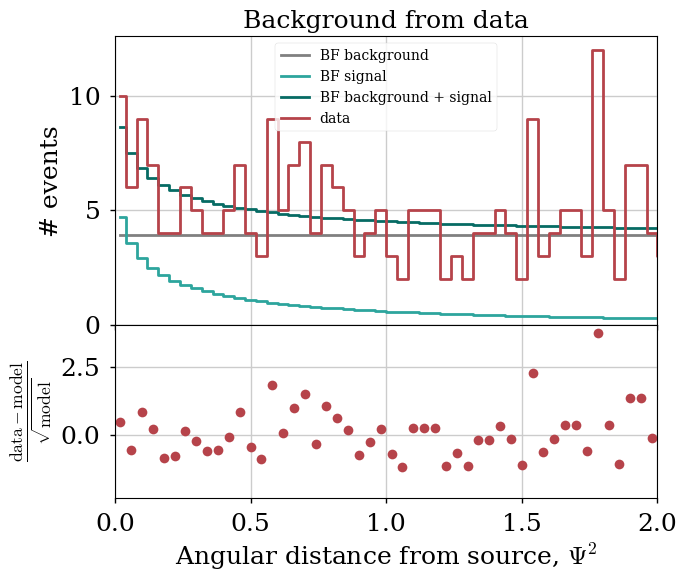

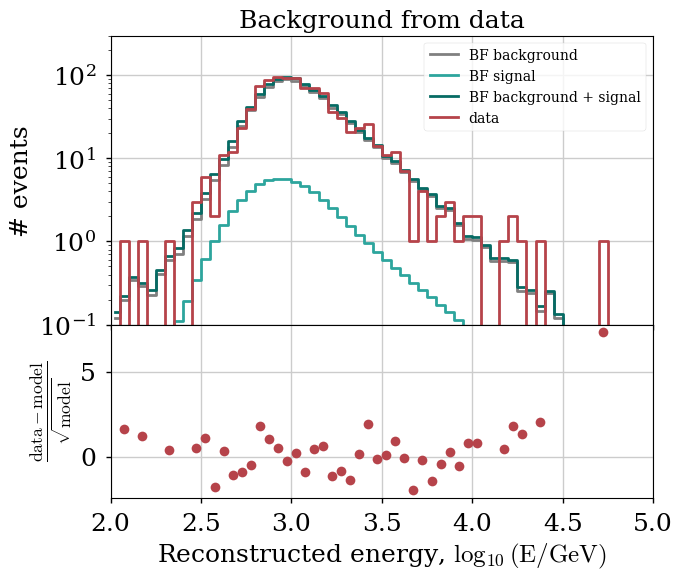

In [43]:
# compare psi and energy histograms of data and best-fit
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data with baseline fluxes
if bg_from_data:
    k_b = data_bg * out_global_pl[0][0]
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg * out_global_pl[0][0],
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )


k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=bf_ngc_flux,  # powerlaw
)

k_sum_bf = k_s + k_b

if bg_from_data:
    title_str = "Background from data"
    save_str = "../../plots/ngc_paper/data-model_{}_dataBG.pdf"
else:
    title_str = "Background from MCEq"
    save_str = "../../plots/ngc_paper/data-model_{}_mceqBG.pdf"

# plot data and baseline flux comparison -- Psi**2
f, axes = plt.subplots(
    nrows=2,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 3], "hspace": 0.0},
)
axes[0].set_title(title_str)
axes[0].plot(
    k_b.bin_mids[0],
    k_b.sum(axis=1),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

axes[0].plot(
    k_s.bin_mids[0], k_s.sum(axis=1), ds="steps-mid", label="BF signal", color=st.colors[1]
)

axes[0].plot(
    k_sum_bf.bin_mids[0],
    k_sum_bf.sum(axis=1),
    ds="steps-mid",
    label="BF background + signal",
    color=st.colors[2],
)
axes[0].plot(
    data_hist.bin_mids[0],
    data_hist.sum(axis=1),
    ds="steps-mid",
    label="data",
    color=st.colors[3],
)
plt.xlabel(r"Angular distance from source, $\Psi^2$")
plt.xlim(0, 2)

axes[1].plot(
    data_hist.bin_mids[0],
    (data_hist.sum(axis=1) - k_sum_bf.sum(axis=1)) / np.sqrt(k_sum_bf.sum(axis=1)),
    lw=0,
    marker="o",
    color=st.colors[3],
)
axes[1].set_ylabel(r"$\rm \frac{data - model}{\sqrt{model}}$")

axes[0].set_ylabel("# events")
axes[0].set_ylim(0, None)
axes[0].legend(loc=0, fontsize="medium")
f.savefig(save_str.format("psi"))

# plot data and baseline flux comparison -- energy
f, axes = plt.subplots(
    nrows=2,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 3], "hspace": 0.0},
)
axes[0].set_title(title_str)
axes[0].plot(
    k_b.bin_mids[1],
    k_b.sum(axis=0),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

axes[0].plot(
    k_s.bin_mids[1], k_s.sum(axis=0), ds="steps-mid", label="BF signal", color=st.colors[1]
)

axes[0].plot(
    k_sum_bf.bin_mids[1],
    k_sum_bf.sum(axis=0),
    ds="steps-mid",
    label="BF background + signal",
    color=st.colors[2],
)
axes[0].plot(
    data_hist.bin_mids[1],
    data_hist.sum(axis=0),
    ds="steps-mid",
    label="data",
    color=st.colors[3],
)
plt.xlim(2, 5)
axes[0].legend(loc=0, fontsize="medium")
axes[0].set_yscale("log")
axes[0].set_ylim(1e-1, 3e2)
plt.xlabel(r"Reconstructed energy, $\rm \log_{10}(E/GeV)$")
axes[0].set_ylabel("# events")
mask = data_hist.sum(axis=0) > 0
axes[1].plot(
    data_hist.bin_mids[1][mask],
    ((data_hist.sum(axis=0) - k_sum_bf.sum(axis=0)) / np.sqrt(k_sum_bf.sum(axis=0)))[
        mask
    ],
    lw=0,
    marker="o",
    color=st.colors[3],
)
axes[1].set_ylabel(r"$\rm \frac{data - model}{\sqrt{model}}$")
#axes[1].set_ylim(-1.5, 6)
f.savefig(save_str.format("energy"))

# Model fits

# Inoue model
model + PL mixture fit

In [44]:
from fluxes import inoue_src_flux

In [45]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

dct = dict(
    shape=["model_flux", "powerlaw"],
    signal_parameters=[1, 2],  # for each of the models
    aeff_factor_b=k_b,  # we use the bg from data
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True,
    flux_shape=inoue_src_flux,
)

bg_llh = lambda x: ps_llh_single((x[0], 0, 0, 3), **dct)

out_bckg = fmin_l_bfgs_b(
    bg_llh,
    x0=(1.1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# full optimization of all parameters of PL model

pl_llh = lambda x: ps_llh_single((x[0], 0, x[1], x[2]), **dct)

# S+B fit
out_global_pl = fmin_l_bfgs_b(
    pl_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)
print("PL Signal fit parameters:", out_global_pl[0])

# significance
pval = chi2.sf(out_bckg[1] - out_global_pl[1], 2)
significance = norm.isf(pval)
print(f"P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

# optimization of Inoue + PL mixture model
model_only_llh = lambda x: ps_llh_single((x[0], x[1], 0, 2), **dct)

# S+B fit
out_inoue_only = fmin_l_bfgs_b(
    model_only_llh,
    x0=(1.2, 1.1),
    bounds=[
        (1e-3, 10),
        (1e-3, 100),
    ],
    approx_grad=True,
)
print("Inoue-only fit parameters:", out_inoue_only[0])

# optimization of Inoue + PL mixture model
model_llh = lambda x: ps_llh_single(x, **dct)

# S+B fit
out_inoue = fmin_l_bfgs_b(
    model_llh,
    x0=(1.2, 1.1, 1.1, ngc_flux.gamma),
    bounds=[
        (1e-3, 10),
        (1e-3, 100),
        (1e-3, 100),
        (1e-3, 10),
    ],
    approx_grad=True,
)
print("Inoue + PL Signal fit parameters:", out_inoue[0])
print(
    "Number of astro events: ",
    np.sum(
        astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            baseline_eres,
            out_inoue_only[0][1],
            inoue_src_flux,
        )
    ),
)
## Significances
# Inoue-only vs atmo-only
ndof = 1
pval = chi2.sf(out_bckg[1] - out_inoue_only[1], ndof)
significance = norm.isf(pval)
print(f"Inoue-only vs atmo-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)


# Inoue mixture vs atmo-only
ndof = 3
pval = chi2.sf(out_bckg[1] - out_inoue[1], ndof)
significance = norm.isf(pval)
print(f"Inoue+PL vs atmo-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

# Inoue mixture vs atmo + PL
ndof = 1
pval = chi2.sf(out_global_pl[1] - out_inoue[1], ndof)
significance = norm.isf(pval)
print(f"Inoue+PL vs PL-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

Atmo-only normalization: [0.99999996]
PL Signal fit parameters: [0.93189545 1.0826587  3.2733312 ]
P-VALUE:3.48e-04 SIGNIFICANCE: 3.390885983197524
Inoue-only fit parameters: [0.9617785 1.8961071]
Inoue + PL Signal fit parameters: [0.92929463 0.95749336 0.5877092  4.03027152]
Number of astro events:  36.31324344725473
Inoue-only vs atmo-only: P-VALUE:5.67e-04 SIGNIFICANCE: 3.255142216768932
Inoue+PL vs atmo-only: P-VALUE:1.05e-03 SIGNIFICANCE: 3.07678128271412
Inoue+PL vs PL-only: P-VALUE:6.20e-01 SIGNIFICANCE: -0.3055078613717246


Text(0, 0.5, '$\\rm \\frac{data - model}{\\sqrt{model}}$')

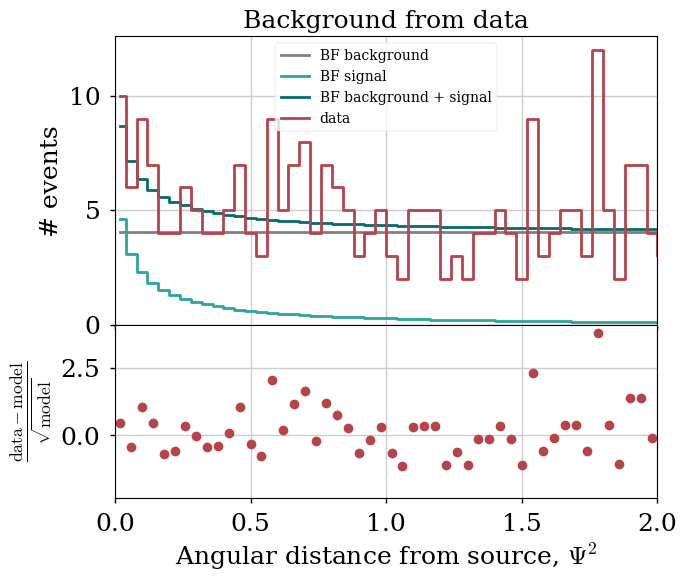

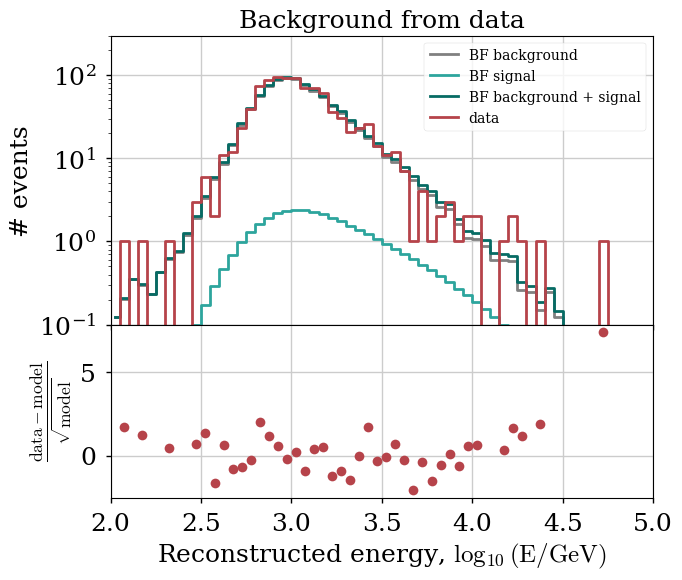

In [46]:
# data PDF agreement
# compare psi and energy histograms of data and best-fit
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data with baseline fluxes
if bg_from_data:
    k_b = data_bg * out_inoue_only[0][0]
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg * out_inoue_only[0][0],
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )


k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=inoue_src_flux,  # powerlaw
) * out_inoue_only[0][1]

k_sum_bf = k_s + k_b

# plot data and baseline flux comparison -- Psi**2
f, axes = plt.subplots(
    nrows=2,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 3], "hspace": 0.0},
)
axes[0].set_title(title_str)
axes[0].plot(
    k_b.bin_mids[0],
    k_b.sum(axis=1),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

axes[0].plot(
    k_s.bin_mids[0], k_s.sum(axis=1), ds="steps-mid", label="BF signal", color=st.colors[1]
)

axes[0].plot(
    k_sum_bf.bin_mids[0],
    k_sum_bf.sum(axis=1),
    ds="steps-mid",
    label="BF background + signal",
    color=st.colors[2],
)
axes[0].plot(
    data_hist.bin_mids[0],
    data_hist.sum(axis=1),
    ds="steps-mid",
    label="data",
    color=st.colors[3],
)
plt.xlabel(r"Angular distance from source, $\Psi^2$")
plt.xlim(0, 2)

axes[1].plot(
    data_hist.bin_mids[0],
    (data_hist.sum(axis=1) - k_sum_bf.sum(axis=1)) / np.sqrt(k_sum_bf.sum(axis=1)),
    lw=0,
    marker="o",
    color=st.colors[3],
)
axes[1].set_ylabel(r"$\rm \frac{data - model}{\sqrt{model}}$")

axes[0].set_ylabel("# events")
axes[0].set_ylim(0, None)
axes[0].legend(loc=0, fontsize="medium")

# plot data and baseline flux comparison -- energy
f, axes = plt.subplots(
    nrows=2,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 3], "hspace": 0.0},
)
axes[0].set_title(title_str)
axes[0].plot(
    k_b.bin_mids[1],
    k_b.sum(axis=0),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

axes[0].plot(
    k_s.bin_mids[1], k_s.sum(axis=0), ds="steps-mid", label="BF signal", color=st.colors[1]
)

axes[0].plot(
    k_sum_bf.bin_mids[1],
    k_sum_bf.sum(axis=0),
    ds="steps-mid",
    label="BF background + signal",
    color=st.colors[2],
)
axes[0].plot(
    data_hist.bin_mids[1],
    data_hist.sum(axis=0),
    ds="steps-mid",
    label="data",
    color=st.colors[3],
)
plt.xlim(2, 5)
axes[0].legend(loc=0, fontsize="medium")
axes[0].set_yscale("log")
axes[0].set_ylim(1e-1, 3e2)
plt.xlabel(r"Reconstructed energy, $\rm \log_{10}(E/GeV)$")
axes[0].set_ylabel("# events")
mask = data_hist.sum(axis=0) > 0
axes[1].plot(
    data_hist.bin_mids[1][mask],
    ((data_hist.sum(axis=0) - k_sum_bf.sum(axis=0)) / np.sqrt(k_sum_bf.sum(axis=0)))[
        mask
    ],
    lw=0,
    marker="o",
    color=st.colors[3],
)
axes[1].set_ylabel(r"$\rm \frac{data - model}{\sqrt{model}}$")
#axes[1].set_ylim(-1.5, 6)

### significance of Inoue-only fit over PL fit with pseudo experiments
idea: TS_exp compared to TS_pe
- with TS_exp = LLH_exp_model - LLH_exp_PL
- and TS_pe = LLH_pe_model - LLH_pe_PL
- pe is bg_from_data + PL signal model at best-fit parameters of PL fit on exp data

In [47]:
dct = dict(
    aeff_factor_b=data_bg,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
)

TS_pl_as_H0 = []

for i in range(200):
    PE = poisson.rvs(mu_expectation.histo)
    # full optimization of all parameters of PL model
    pl_llh = lambda x: ps_llh_single(x, k_i=PE, shape="powerlaw", **dct)
    # S+B fit
    out_pl_pe = fmin_l_bfgs_b(
        pl_llh,
        x0=(1, 1, ngc_flux.gamma),
        bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
        approx_grad=True,
    )

    model_llh = lambda x: ps_llh_single(
        x, k_i=PE, shape="model_flux", flux_shape=inoue_src_flux, **dct
    )

    # S+B fit
    out_inoue_pe = fmin_l_bfgs_b(
        model_llh,
        x0=(1.2, 1.1),
        bounds=[(1e-3, 10), (1e-3, 100)],
        approx_grad=True,
    )

    TS_pl_as_H0.append(
        {
            "TS": out_pl_pe[1] - out_inoue_pe[1],
            "pl_bg_norm": out_pl_pe[0][0],
            "pl_norm": out_pl_pe[0][1],
            "pl_gamma": out_pl_pe[0][2],
            "inoue_bg": out_inoue_pe[0][0],
            "inoue_norm": out_inoue_pe[0][1],
        }
    )

TS_pl_as_H0 = pd.DataFrame(TS_pl_as_H0)


<Figure size 1200x1200 with 0 Axes>

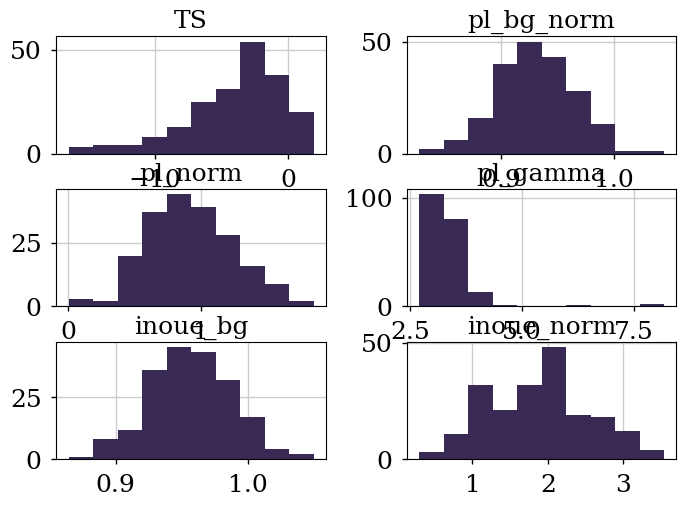

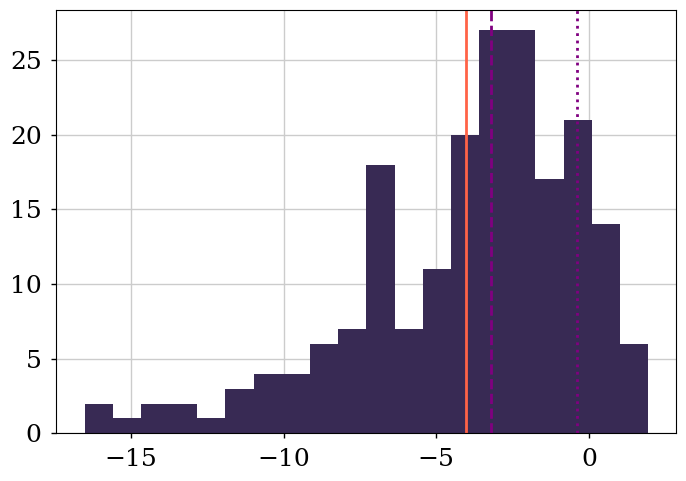

In [48]:
plt.figure(figsize=(12,12))
TS_pl_as_H0.hist()

plt.figure()
plt.hist(TS_pl_as_H0.TS, bins=20)
plt.axvline(out_global_pl[1] - out_inoue_only[1], color="tomato")
plt.axvline(np.median(TS_pl_as_H0.TS), color="purple", ls="--")
plt.axvline(np.quantile(TS_pl_as_H0.TS, 0.5 + 0.34), color="purple", ls=":")

# Kheirandish model

In [49]:
from fluxes import kheirandish_src_flux

In [50]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

dct = dict(
    shape=["model_flux", "powerlaw"],
    signal_parameters=[1, 2],  # for each of the models
    aeff_factor_b=k_b,  # we use the bg from data
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True,
    flux_shape=kheirandish_src_flux,
)

bg_llh = lambda x: ps_llh_single((x[0], 0, 0, 3), **dct)

out_bckg = fmin_l_bfgs_b(
    bg_llh,
    x0=(1.1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# full optimization of all parameters of PL model

pl_llh = lambda x: ps_llh_single((x[0], 0, x[1], x[2]), **dct)

# S+B fit
out_global_pl = fmin_l_bfgs_b(
    pl_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)
print("PL Signal fit parameters:", out_global_pl[0])

# significance
pval = chi2.sf(out_bckg[1] - out_global_pl[1], 2)
significance = norm.isf(pval)
print(f"P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

# optimization of DK + PL mixture model
model_only_llh = lambda x: ps_llh_single((x[0], x[1], 0, 2), **dct)

# S+B fit
out_kheirandish_only = fmin_l_bfgs_b(
    model_only_llh,
    x0=(1.2, 1.1),
    bounds=[
        (1e-3, 10),
        (1e-3, 100),
    ],
    approx_grad=True,
)
print("kheirandish-only fit parameters:", out_kheirandish_only[0])

# optimization of kheirandish + PL mixture model
model_llh = lambda x: ps_llh_single(x, **dct)

# S+B fit
out_kheirandish = fmin_l_bfgs_b(
    model_llh,
    x0=(1.2, 1.1, 1.1, ngc_flux.gamma),
    bounds=[
        (1e-3, 10),
        (1e-3, 100),
        (1e-3, 100),
        (1e-3, 10),
    ],
    approx_grad=True,
)
print("kheirandish + PL Signal fit parameters:", out_kheirandish[0])
print(
    "Number of astro events: ",
    np.sum(
        astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            baseline_eres,
            out_kheirandish_only[0][1],
            kheirandish_src_flux,
        )
    ),
)
## Significances
# kheirandish-only vs atmo-only
ndof = 1
pval = chi2.sf(out_bckg[1] - out_kheirandish_only[1], ndof)
significance = norm.isf(pval)
print(f"kheirandish-only vs atmo-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)


# kheirandish mixture vs atmo-only
ndof = 3
pval = chi2.sf(out_bckg[1] - out_kheirandish[1], ndof)
significance = norm.isf(pval)
print(f"kheirandish+PL vs atmo-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

# kheirandish  mixture vs atmo + PL
ndof = 1
pval = chi2.sf(out_global_pl[1] - out_kheirandish[1], ndof)
significance = norm.isf(pval)
print(f"kheirandish+PL vs PL-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

Atmo-only normalization: [0.99999996]
PL Signal fit parameters: [0.93189545 1.0826587  3.2733312 ]
P-VALUE:3.48e-04 SIGNIFICANCE: 3.390885983197524
kheirandish-only fit parameters: [0.96241945 1.46737264]
kheirandish + PL Signal fit parameters: [0.92925174 0.78343783 0.53700681 4.11697221]
Number of astro events:  35.707669356589484
kheirandish-only vs atmo-only: P-VALUE:6.33e-04 SIGNIFICANCE: 3.223453697841581
kheirandish+PL vs atmo-only: P-VALUE:1.14e-03 SIGNIFICANCE: 3.050639606610087
kheirandish+PL vs PL-only: P-VALUE:8.05e-01 SIGNIFICANCE: -0.8604095864013133


## kheirandish vs PL

In [51]:

dct = dict(
    aeff_factor_b=data_bg,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
)

TS_pl_as_H0_kh = []

for i in range(200):
    PE = poisson.rvs(mu_expectation.histo)
    # full optimization of all parameters of PL model
    pl_llh = lambda x: ps_llh_single(x, k_i=PE, shape="powerlaw", **dct)
    # S+B fit
    out_pl_pe = fmin_l_bfgs_b(
        pl_llh,
        x0=(1, 1, ngc_flux.gamma),
        bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
        approx_grad=True,
    )

    model_llh = lambda x: ps_llh_single(
        x, k_i=PE, shape="model_flux", flux_shape=kheirandish_src_flux, **dct
    )

    # S+B fit
    out_kheirandish_pe = fmin_l_bfgs_b(
        model_llh,
        x0=(1.2, 1.1),
        bounds=[(1e-3, 10), (1e-3, 100)],
        approx_grad=True,
    )

    TS_pl_as_H0_kh.append(
        {
            "TS": out_pl_pe[1] - out_kheirandish_pe[1],
            "pl_bg_norm": out_pl_pe[0][0],
            "pl_norm": out_pl_pe[0][1],
            "pl_gamma": out_pl_pe[0][2],
            "inoue_bg": out_kheirandish_pe[0][0],
            "inoue_norm": out_kheirandish_pe[0][1],
        }
    )
TS_pl_as_H0_kh = pd.DataFrame(TS_pl_as_H0_kh)


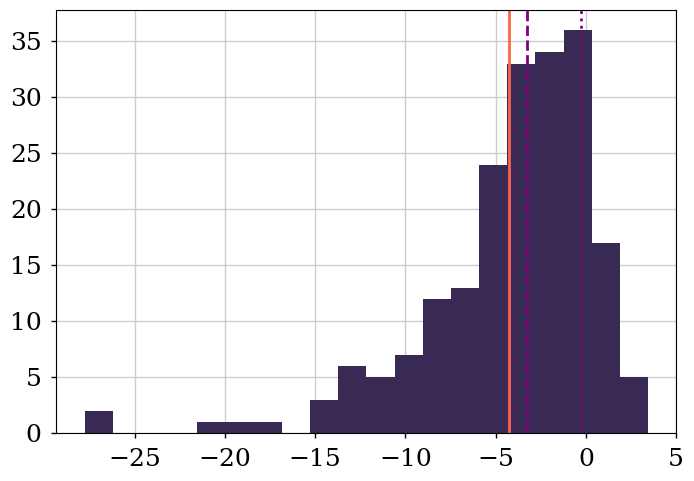

In [52]:
plt.hist(TS_pl_as_H0_kh.TS, bins=20)

plt.axvline(out_global_pl[1] - out_kheirandish_only[1], color="tomato")
plt.axvline(np.median(TS_pl_as_H0_kh.TS), color="purple", ls="--")
plt.axvline(np.quantile(TS_pl_as_H0_kh.TS, 0.5 + 0.34), color="purple", ls=":")

# profile likelihood 1D

In [53]:
if True:
    ident = "IceCube"
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    # asimov data with baseline fluxes

    if bg_from_data:
        k_b = data_bg
        print("BG from data")
    else:
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
        k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
        )
        print("BG from MCEq")

    dct = dict(
        shape="powerlaw",
        aeff_factor_b=k_b,
        aeff_factor_s=aeff_factor_signal,
        k_i=data_hist,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
    )

    sig_ts = []
    num = 50
    g_space = np.linspace(2.45, 4.5, num=num+1)
    ns_space = np.linspace(0.2, 1.8, num=num)

    for g in g_space:
        tmp = {}
        tmp["Spectral index"] = g
        tmp["fixed"] = "Spectral index"

        _llh = lambda x: ps_llh_single((x[0], x[1], g), **dct)

        # S+B fit
        out_profile = fmin_l_bfgs_b(
            _llh,
            x0=(1, 1),
            bounds=[(1E-3, 10), (1E-3, 10)],
            approx_grad=True,
        )

        tmp["ts"] = out_profile[1]
        tmp["$-2\Delta$ LLH"] = out_profile[1] - out_global_pl[1]
        tmp["nb"] = out_profile[0][0]
        tmp["Flux normalization relative to baseline flux"] = out_profile[0][1]
        sig_ts.append(tmp)

    for s in ns_space:
        tmp = {}
        tmp["Flux normalization relative to baseline flux"] = s
        tmp["fixed"] = "Flux normalization relative to baseline flux"

        _llh = lambda x: ps_llh_single((x[0], s, x[1]), **dct)

        # S+B fit
        out_profile = fmin_l_bfgs_b(
            _llh,
            x0=(1, 3),
            bounds=[(1E-3, 10), (0.1, 10)],
            approx_grad=True,
        )

        tmp["ts"] = out_profile[1]
        tmp["$-2\Delta$ LLH"] = out_profile[1] - out_global_pl[1]
        tmp["nb"] = out_profile[0][0]
        tmp["Spectral index"] = out_profile[0][1]
        sig_ts.append(tmp)

    sig_ts = pd.DataFrame(sig_ts)
    savestr = "MCEq" if bg_from_data == False else "dataBG"
    sig_ts.to_csv(join(st.BASEPATH, f"resources/ngc_2D_LLH_scan_exp_{savestr}_1D.csv"), index=False)

BG from data


(2.45, 4.5)

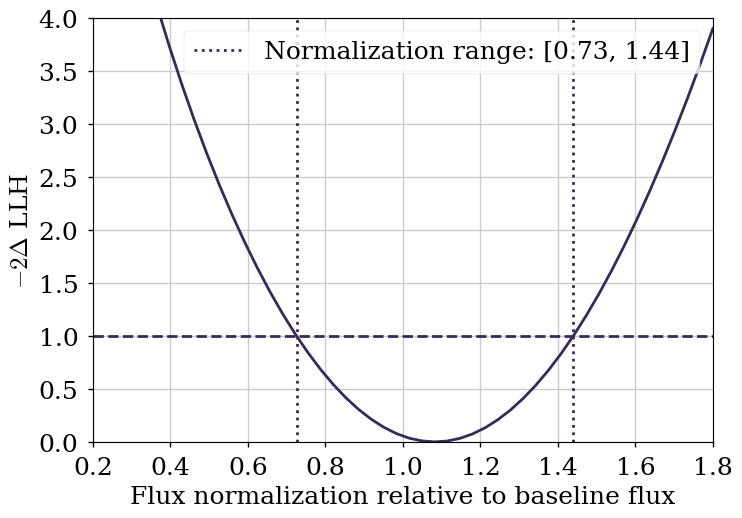

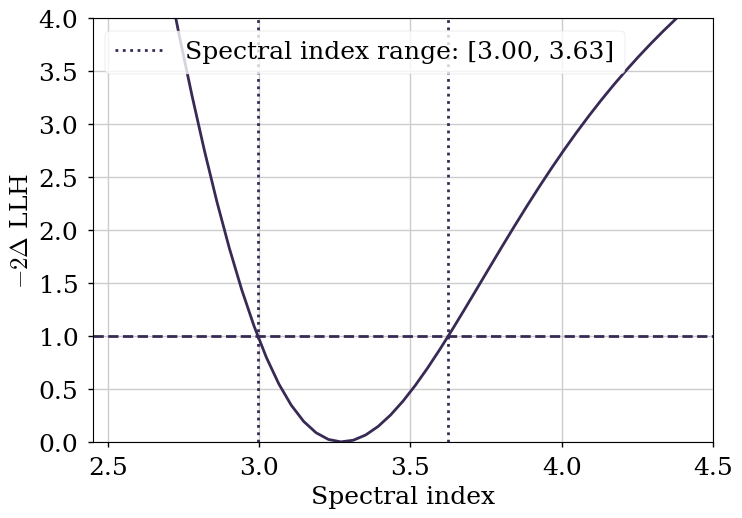

In [54]:
plt.figure()
selection = sig_ts.loc[sig_ts.fixed == "Flux normalization relative to baseline flux"]
# calculate 1sigma range
spline = InterpolatedUnivariateSpline(
    selection["Flux normalization relative to baseline flux"],
    selection["$-2\Delta$ LLH"] - 1,
)
ns_range = spline.roots()

sns.lineplot(
    data=selection,
    x="Flux normalization relative to baseline flux",
    y="$-2\Delta$ LLH",
)
plt.axhline(1, ls="--")
plt.axvline(ns_range[0], ls=":")
plt.axvline(ns_range[1], ls=":", label=f"Normalization range: [{ns_range[0]:1.2f}, {ns_range[1]:1.2f}]")
plt.legend(loc=0)
plt.ylim(0, 4)
plt.xlim(ns_space[0], ns_space[-1])

plt.figure()
selection = sig_ts.loc[sig_ts.fixed == "Spectral index"]
spline = InterpolatedUnivariateSpline(
    selection["Spectral index"],
    selection["$-2\Delta$ LLH"] - 1,
)
gamma_range = spline.roots()

sns.lineplot(
    data=selection,
    x="Spectral index",
    y="$-2\Delta$ LLH",
)
plt.axhline(1, ls="--")
plt.axvline(gamma_range[0], ls=":")
plt.axvline(gamma_range[1], ls=":", label=f"Spectral index range: [{gamma_range[0]:1.2f}, {gamma_range[1]:1.2f}]")
plt.legend(loc=0)
plt.ylim(0, 4)
plt.xlim(g_space[0], g_space[-1])

In [55]:
n_avg_err = np.mean(np.abs(ns_range - out_global_pl[0][1]))
gamma_avg_err = np.mean(np.abs(gamma_range - out_global_pl[0][2]))
print(n_avg_err, gamma_avg_err)
with open(join(st.BASEPATH, "resources/param_errors.pckl"), "wb") as f:
    pickle.dump((n_avg_err, gamma_avg_err), f)

0.3571030779738327 0.31506775487868577


# profile likelihood 2D
Contour -> optimize nb on a gamma-ns grid
Also, cross-check the BF results for the Global LLH


In [56]:
if True:
    ident = "IceCube"
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
    # asimov data with baseline fluxes

    if bg_from_data:
        k_b = data_bg
        print("BG from data")
    else:
        aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
        k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
        )
        print("BG from MCEq")

    dct = dict(
        shape="powerlaw",
        aeff_factor_b=k_b,
        aeff_factor_s=aeff_factor_signal,
        k_i=data_hist,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
        energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
    )

    sig_ts = []
    num = 50
    g_space = np.linspace(2.45, 4.5, num=num+1)
    ns_space = np.logspace(-0.9, 0.5, num=num)

    for g, s in product(g_space, ns_space):
        tmp = {}
        tmp["ns"] = s
        tmp["gamma"] = g

        _llh = lambda x: ps_llh_single((x[0], s, g), **dct)

        # S+B fit
        out_profile = fmin_l_bfgs_b(
            _llh,
            x0=(1, ),
            bounds=[(1E-3, 10),],
            approx_grad=True,
        )

        tmp["ts"] = out_profile[1]
        tmp["delta_ts"] = out_profile[1] - out_global_pl[1]
        tmp["nb"] = out_profile[0][0]
        sig_ts.append(tmp)

    sig_ts = pd.DataFrame(sig_ts)
    savestr = "MCEq" if bg_from_data == False else "dataBG"
    sig_ts.to_csv(join(st.BASEPATH, f"resources/ngc_2D_LLH_scan_exp_{savestr}.csv"), index=False)

BG from data


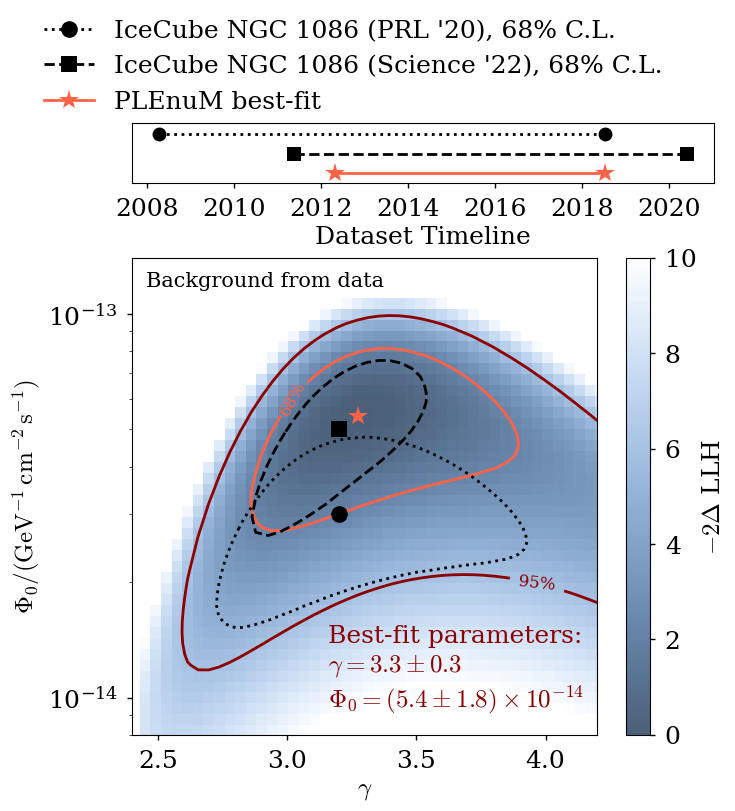

In [57]:
savestr = "MCEq" if bg_from_data == False else "dataBG"
sig_ts = pd.read_csv(join(st.BASEPATH, f"resources/ngc_2D_LLH_scan_exp_{savestr}.csv"))
sig_ts["norm"] = sig_ts["ns"] * ngc_flux.norm
sig_ts_piv = sig_ts.pivot(index="norm", columns="gamma", values="delta_ts")
cvals = [0.32, 0.05]
lbs = ["68%", "95%"]
levels = chi2.isf(cvals, 2)

f, axes = plt.subplots(
    figsize=(7.5, 9), nrows=2, gridspec_kw={"height_ratios": [1, 8], "hspace": 0.28}
)

ax = axes[0]
# timeline
for ii, key in enumerate(collect_times):
    if key == "all":
        continue
    ax.plot(
        collect_times[key]["data"],
        np.repeat(ii, len(collect_times[key]["data"])),
        **collect_times[key]["plotting_kw"],
    )

ax.set_yticks([])
ax.grid(False)
ax.set_ylim(-0.5, 2.6)
ax.set_xlabel("Dataset Timeline")

ax = axes[1]

im = ax.pcolormesh(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    vmin=0,
    vmax=10,
    cmap=cur_cmap,
    alpha=0.8,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(im)
cb.set_label(r"$-2 \Delta$ LLH")

ax.plot(gamma_c_68_prev, phi_c_68_prev, color="k", ls=":")
ax.plot(
    3.2,
    3e-14,
    color="k",
    marker="o",
    label="IceCube NGC 1086 (PRL '20), 68% C.L.",
    ms=12,
    ls=":",
)

ax.plot(gamma_c_68, phi_c_68 * 1e-3, color="k", ls="--")
ax.plot(
    3.2,
    5e-14,
    color="k",
    marker="s",
    label="IceCube NGC 1086 (Science '22), 68% C.L.",
    ms=12,
    ls="--",
)


ax.plot(
    out_global_pl[0][2],
    out_global_pl[0][1] * ngc_flux.norm,
    color="tomato",
    marker="*",
    ms=15,
    label="PLEnuM best-fit",
)
sc = ax.contour(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    levels=levels,
    lw=3,
    colors=["tomato", "darkred"],
    zorder=1,
)

fmt = {l: s for l, s in zip(sc.levels, lbs)}
plt.clabel(sc, levels, fmt=fmt, fontsize=12)


ax.set_xlabel(r"$\gamma$")
ax.set_ylabel(r"$\Phi_0 / ({\rm GeV^{-1}\, cm^{-2}\, s^{-1}})$")
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.42, 0.93),
)
if bg_from_data:
    title_str = "Background from data"
    save_str = "../../plots/ngc_paper/experimental_data_2Dscan.pdf"
else:
    title_str = "Background from MCEq"
    save_str = "../../plots/ngc_paper/experimental_data_2Dscan_MCEq.pdf"
ax.text(0.03, 0.94, title_str, fontsize=15, transform=ax.transAxes)
ax.text(
    0.42,
    0.06,
    "Best-fit parameters:\n"
    + rf"$\gamma={out_global_pl[0][2]:1.1f}\pm{gamma_avg_err:1.1f}$"
    + "\n"
    + rf"$\Phi_0=({out_global_pl[0][1] * ngc_flux.norm * 1E14:1.1f}\pm{n_avg_err * ngc_flux.norm * 1E14:1.1f})\times 10^{{-14}}$",
    fontsize=18,
    transform=ax.transAxes,
    ha="left",
    color="darkred",
)


ax.set_yscale("log")
# ax.set_ylim(6e-15, 1e-13)
ax.set_ylim(8e-15, 1.4e-13)
ax.set_xlim(2.4, 4.2)
plt.grid(False)

f.subplots_adjust(top=0.79)
#f.savefig(save_str, bbox_inches="tight", dpi=200)
# see plotting_standalone.ipynb for final version

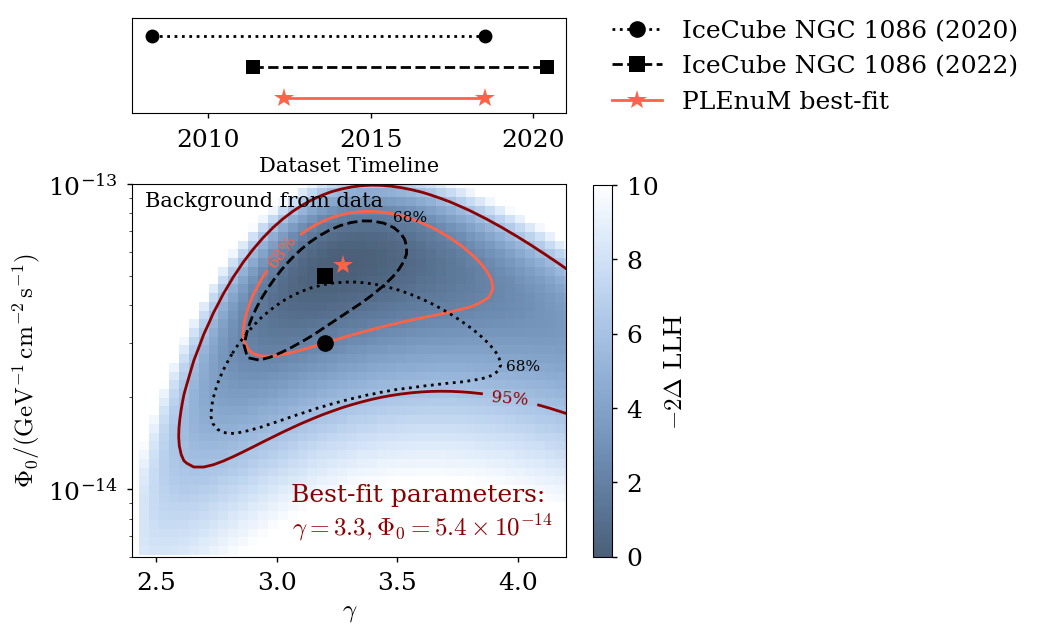

In [58]:
### more landscape-y version -- OLD
savestr = "MCEq" if bg_from_data == False else "dataBG"
sig_ts = pd.read_csv(join(st.BASEPATH, f"resources/ngc_2D_LLH_scan_exp_{savestr}.csv"))
sig_ts["norm"] = sig_ts["ns"] * ngc_flux.norm
sig_ts_piv = sig_ts.pivot(index="norm", columns="gamma", values="delta_ts")
cvals = [0.32, 0.05]
lbs = ["68%", "95%"]
levels = chi2.isf(cvals, 2)

f, axes = plt.subplots(
    figsize=(7, 7), nrows=2, gridspec_kw={"height_ratios": [2.05, 8], "hspace": 0.3}
)

ax = axes.flatten()[0]
# timeline
for ii, key in enumerate(collect_times):
    if key == "all":
        continue
    ax.plot(
        collect_times[key]["data"],
        np.repeat(ii, len(collect_times[key]["data"])),
        **collect_times[key]["plotting_kw"],
    )

ax.set_yticks([])
ax.grid(False)
ax.set_ylim(-0.5, 2.6)
ax.set_xlabel("Dataset Timeline", fontsize=15)

ax = axes.flatten()[1]
im = ax.pcolormesh(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    vmin=0,
    vmax=10,
    cmap=cur_cmap,
    alpha=0.8,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(im, ax=axes, anchor=(0,0), shrink=0.69)
cb.set_label(r"$-2 \Delta$ LLH")

ax.plot(gamma_c_68_prev, phi_c_68_prev, color="k", ls=":")
ax.plot(
    3.2,
    3e-14,
    color="k",
    marker="o",
    label="IceCube NGC 1086 (2020)",
    ms=12,
    ls=":",
)

ax.plot(gamma_c_68, phi_c_68 * 1e-3, color="k", ls="--")
ax.plot(
    3.2,
    5e-14,
    color="k",
    marker="s",
    label="IceCube NGC 1086 (2022)",
    ms=12,
    ls="--",
)


ax.plot(
    out_global_pl[0][2],
    out_global_pl[0][1] * ngc_flux.norm,
    color="tomato",
    marker="*",
    ms=15,
    label="PLEnuM best-fit",
)
sc = ax.contour(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    levels=levels,
    lw=3,
    colors=["tomato", "darkred"],
    zorder=1,
)

fmt = {l: s for l, s in zip(sc.levels, lbs)}
plt.clabel(sc, levels, fmt=fmt, fontsize=12)


ax.set_xlabel(r"$\gamma$")
ax.set_ylabel(r"$\Phi_0 / ({\rm GeV^{-1}\, cm^{-2}\, s^{-1}})$")
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(1.1, 0.91),
)
if bg_from_data:
    title_str = "Background from data"
    save_str = "../../plots/ngc_paper/experimental_data_2Dscan.svg"
else:
    title_str = "Background from MCEq"
    save_str = "../../plots/ngc_paper/experimental_data_2Dscan_MCEq.pdf"
ax.text(0.03, 0.94, title_str, fontsize=15, transform=ax.transAxes)
ax.text(
    0.97,
    0.06,
    "Best-fit parameters: \n"
    + rf"$\gamma={out_global_pl[0][2]:1.1f}, \Phi_0={out_global_pl[0][1] * ngc_flux.norm * 1E14:1.1f}\times 10^{{-14}}$",
    fontsize=18,
    transform=ax.transAxes,
    ha="right",
    color="darkred",
)
ax.text(
    0.6,
    0.9,
    "68%",
    fontsize=11,
    transform=ax.transAxes,
)

ax.text(
    0.86,
    0.5,
    "68%",
    fontsize=11,
    transform=ax.transAxes,
)

ax.set_yscale("log")
ax.set_ylim(6e-15, 1e-13)
ax.set_xlim(2.4, 4.2)
ax.grid(False)

# f.savefig(save_str, bbox_inches="tight", dpi=200)


# analysis - spectral fit


## cutoff

Atmo-only normalization: [0.99999996]
PL Signal fit parameters: [0.93189545 1.0826587  3.2733312 ]
P-VALUE:3.48e-04 SIGNIFICANCE: 3.390885983197524
PLC Signal fit parameters: [0.93198809 1.08297269 3.26577324 6.21136407]
PLC (norm+ecut) Signal fit parameters: [0.94016854 1.50558986 3.452496  ]
PLC vs PL: P-VALUE:9.62e-01 SIGNIFICANCE: -1.7778195638077792
PLC vs atmo-only: P-VALUE:1.17e-03 SIGNIFICANCE: 3.042327903619951
PLC (norm-only) vs atmo-only: P-VALUE:1.74e-04 SIGNIFICANCE: 3.576110587650781


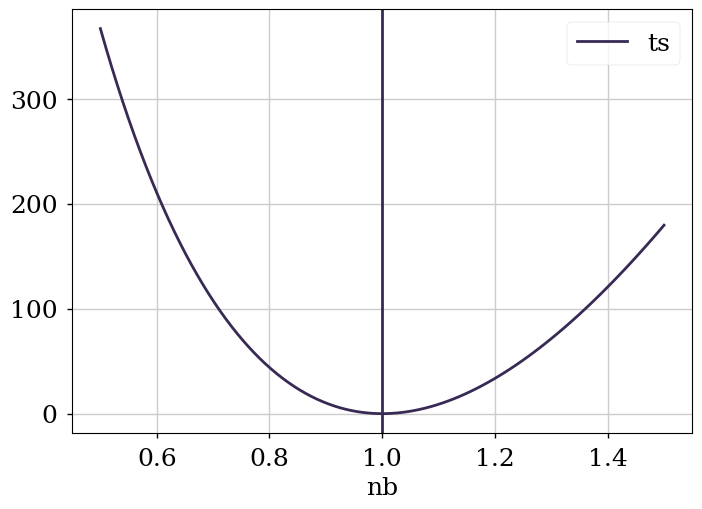

In [59]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

dct = dict(
    shape="powerlaw",
    aeff_factor_b=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
)

bg_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)

out_bckg = fmin_l_bfgs_b(
    bg_llh,
    x0=(1.1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# make parameter scans as crosscheck
# background-only scan
bg_ts = []
for nb in np.linspace(0.5, 1.5, 100):
    bg_ts.append({"ts": ps_llh_single((nb, 0, 3), **dct) - out_bckg[1], "nb": nb})

bg_ts = pd.DataFrame(bg_ts)
bg_ts.plot(x="nb", y="ts")
plt.axvline(out_bckg[0])

# full optimization of all parameters of PL model

pl_llh = lambda x: ps_llh_single(x, **dct)

# S+B fit
out_global_pl = fmin_l_bfgs_b(
    pl_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)
print("PL Signal fit parameters:", out_global_pl[0])

# significance
pval = chi2.sf(out_bckg[1] - out_global_pl[1], 2)
significance = norm.isf(pval)
print(f"P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

# full optimization of all parameters of PLC model
dct.pop("shape")
plc_llh = lambda x: ps_llh_single(x, shape="powerlaw with cutoff", **dct)

# S+B fit
out_global_plc = fmin_l_bfgs_b(
    plc_llh,
    x0=(1.2, 1.1, 1.9, 3.4),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10), (1e-1, 15)],
    approx_grad=True,
)
print("PLC Signal fit parameters:", out_global_plc[0])

# optimization of only normalization & ecut of PLC model
# keep gamma fixed to 2
plc_llh_norm = lambda x: ps_llh_single((x[0], x[1], st.Gamma_cut, x[2]), shape="powerlaw with cutoff", **dct)

# S+B fit
out_global_plc_norm = fmin_l_bfgs_b(
    plc_llh_norm,
    x0=(1.2, 1.1, 3.4), #, 1.9, 3.4),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-1, 15)],# (1e-3, 10), (1e-1, 15)],
    approx_grad=True,
)
print("PLC (norm+ecut) Signal fit parameters:", out_global_plc_norm[0])

# significance
pval = chi2.sf(out_global_pl[1] - out_global_plc[1], 1)
significance = norm.isf(pval)
print(f"PLC vs PL: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

pval = chi2.sf(out_bckg[1] - out_global_plc[1], 3)
significance = norm.isf(pval)
print(f"PLC vs atmo-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)


pval = chi2.sf(out_bckg[1] - out_global_plc_norm[1], 1)
significance = norm.isf(pval)
print(f"PLC (norm-only) vs atmo-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)


In [60]:
# make parameter scans as crosscheck
# cutoff-energy scan with free gamma
plc_ts = []

dct = dict(
    shape="powerlaw with cutoff",
    aeff_factor_b=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
)

for ecut in np.linspace(2, 6, 100):
    plc_llh_local = lambda x: ps_llh_single(
        (x[0], x[1], x[2], ecut), **dct
    )
    _out = fmin_l_bfgs_b(
                plc_llh_local,
                x0=(1.2, 1.1, 1.9),
                bounds=[(1e-3, 10), (1e-3, 20), (1e-3, 10)],
                approx_grad=True,
            )
    plc_ts.append(
        {
            "llh": _out[1],
            "ns": _out[0][1],
            "gamma": _out[0][2],
            "ecut": ecut,
        }
    )

plc_ts = pd.DataFrame(plc_ts)
plc_ts["ts"] = plc_ts["llh"] - plc_ts["llh"].min()


(0.0, 9.0)

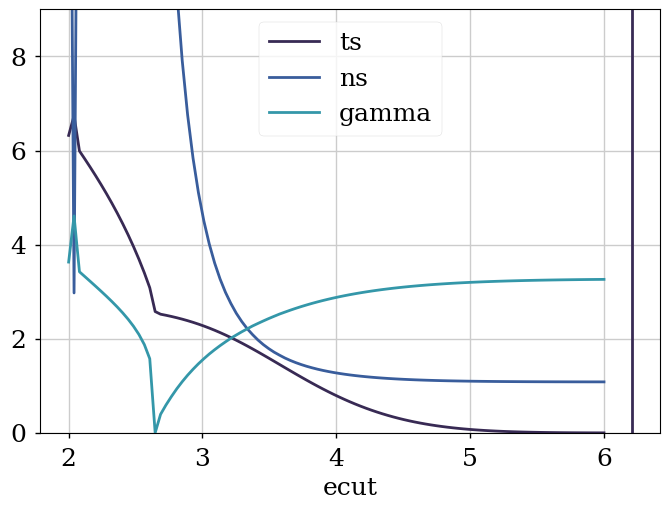

In [61]:

ax = plc_ts.plot(x="ecut", y="ts")
plc_ts.plot(x="ecut", y="ns", ax=ax)
plc_ts.plot(x="ecut", y="gamma", ax=ax)
plt.axvline(out_global_plc[0][-1])
plt.ylim(0, 9)

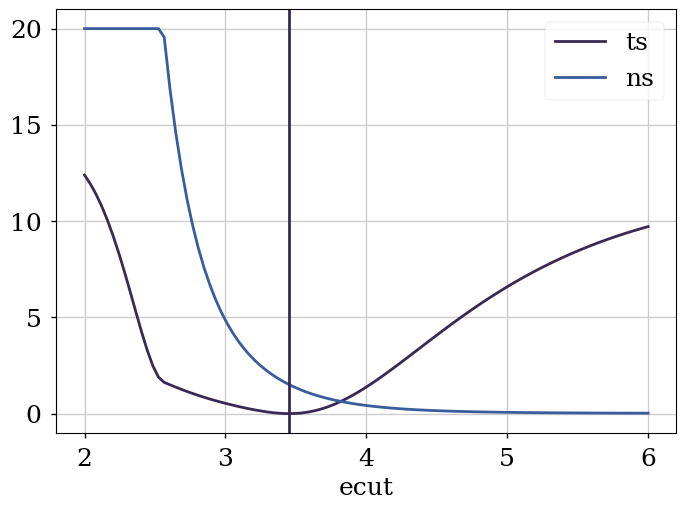

In [62]:
# make parameter scans as crosscheck
# cutoff-energy scan with fixed gamma=2
plc_ts = []

dct = dict(
    shape="powerlaw with cutoff",
    aeff_factor_b=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
)

for ecut in np.linspace(2, 6, 100):
    plc_llh_local = lambda x: ps_llh_single(
        (x[0], x[1], st.Gamma_cut, ecut), **dct
    )
    _out = fmin_l_bfgs_b(
                plc_llh_local,
                x0=(1.2, 1.1), #, 1.9),
                bounds=[(1e-3, 10), (1e-3, 20)],# (1e-3, 10)],
                approx_grad=True,
            )
    plc_ts.append(
        {
            "llh": _out[1],
            "ns": _out[0][1],
            #"gamma": _out[0][2],
            "ecut": ecut,
        }
    )

plc_ts = pd.DataFrame(plc_ts)
plc_ts["ts"] = plc_ts["llh"] - plc_ts["llh"].min()

ax = plc_ts.plot(x="ecut", y="ts")
plc_ts.plot(x="ecut", y="ns", ax=ax)
#plc_ts.plot(x="ecut", y="gamma", ax=ax)
plt.axvline(out_global_plc_norm[0][-1])

### compare to PL

In [63]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

dct = dict(
    aeff_factor_b=data_bg,  # we use the bg from data
    aeff_factor_s=aeff_factor_signal,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
)
## baseline fits on data
# define LLH
pl_llh = lambda x: ps_llh_single(x, k_i=data_hist, shape="powerlaw", **dct)
plc_llh_norm = lambda x: ps_llh_single(
    (x[0], x[1], st.Gamma_cut, x[2]), shape="powerlaw with cutoff", k_i=data_hist, **dct
)

# S+B fit
out_global_pl = fmin_l_bfgs_b(
    pl_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)

# S+B fit
out_global_plc_norm = fmin_l_bfgs_b(
    plc_llh_norm,
    x0=(1.2, 1.1, 3.4),  # , 1.9, 3.4),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-1, 15)],  # (1e-3, 10), (1e-1, 15)],
    approx_grad=True,
)


TS_pl_as_H0_plc = []

for i in range(100):
    PE = poisson.rvs(mu_expectation.histo)
    # full optimization of all parameters of PL model
    pl_llh = lambda x: ps_llh_single(x, k_i=PE, shape="powerlaw", **dct)
    # S+B fit
    out_pl_pe = fmin_l_bfgs_b(
        pl_llh,
        x0=(1, 1, ngc_flux.gamma),
        bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
        approx_grad=True,
    )

    plc_llh_norm = lambda x: ps_llh_single(
        (x[0], x[1], st.Gamma_cut, x[2]), shape="powerlaw with cutoff", k_i=PE, **dct
    )

    # S+B fit
    out_pe_plc_norm = fmin_l_bfgs_b(
        plc_llh_norm,
        x0=(1.2, 1.1, 3.4),
        bounds=[(1e-3, 10), (1e-3, 10), (1e-1, 15)],  # (1e-3, 10), (1e-1, 15)],
        approx_grad=True,
    )

    TS_pl_as_H0_plc.append(
        {
            "TS": out_pl_pe[1] - out_pe_plc_norm[1],
            "pl_bg_norm": out_pl_pe[0][0],
            "pl_norm": out_pl_pe[0][1],
            "pl_gamma": out_pl_pe[0][2],
            "plc_bg": out_pe_plc_norm[0][0],
            "plc_norm": out_pe_plc_norm[0][1],
            "plc_cut": out_pe_plc_norm[0][2],
        }
    )
TS_pl_as_H0_plc = pd.DataFrame(TS_pl_as_H0_plc)

<Figure size 1200x1200 with 0 Axes>

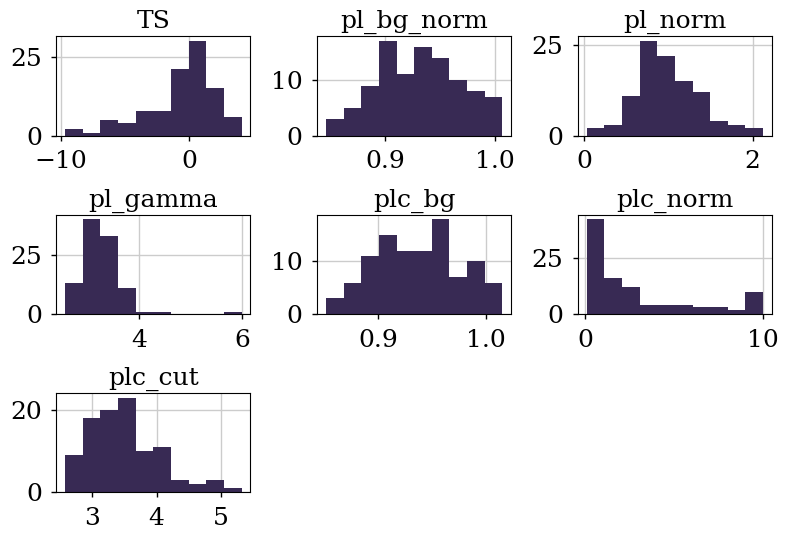

In [64]:
plt.figure(figsize=(12,12))
TS_pl_as_H0_plc.hist()
plt.tight_layout()


In [65]:
out_global_pl[1] - out_global_plc_norm[1]

-1.835814638852753

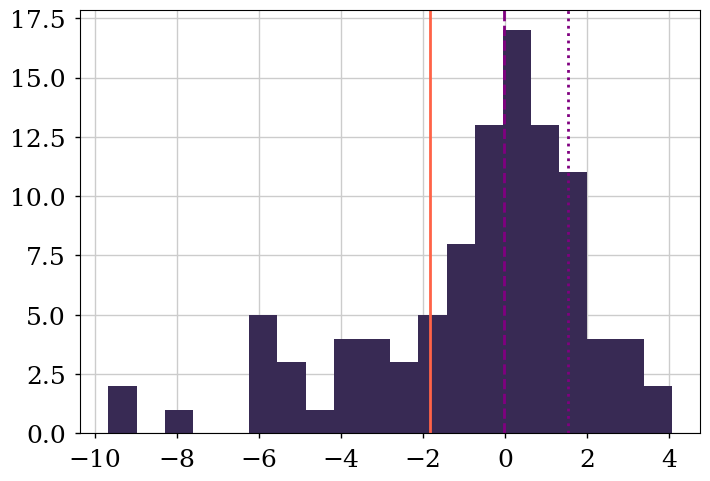

In [66]:
plt.hist(TS_pl_as_H0_plc.TS, bins=20)
plt.axvline(out_global_pl[1] - out_global_plc_norm[1], color="tomato")
plt.axvline(np.median(TS_pl_as_H0_plc.TS), color="purple", ls="--")
plt.axvline(np.quantile(TS_pl_as_H0_plc.TS, 0.5 + 0.34), color="purple", ls=":")

### data model agreement

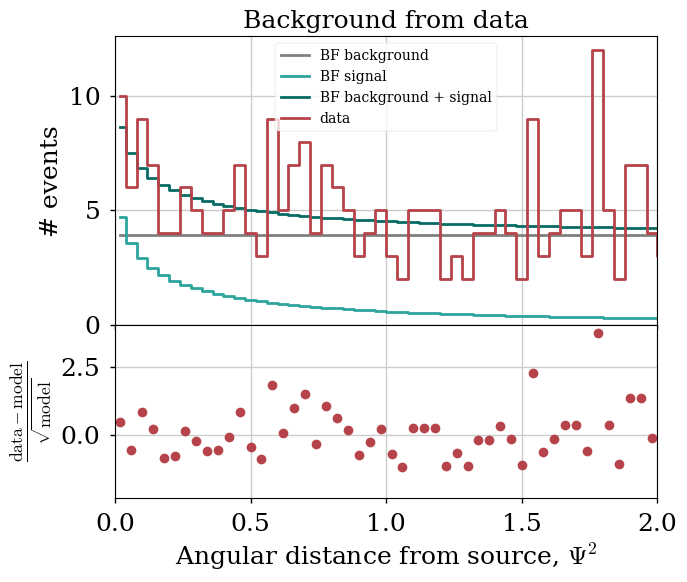

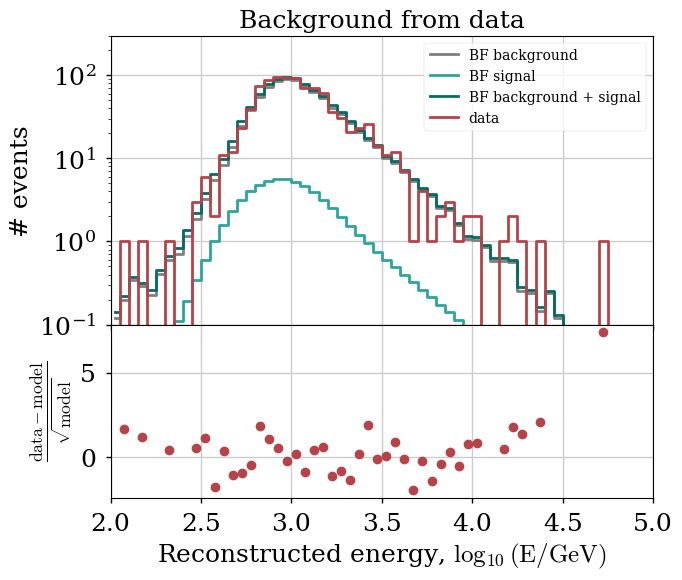

In [67]:
# compare psi and energy histograms of data and best-fit
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data with baseline fluxes
if bg_from_data:
    k_b = data_bg * out_global_plc[0][0]
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg * out_global_plc[0][0],
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

bf_ngc_flux = PLcut_flux(
    ngc_flux.norm * out_global_plc[0][1],
    out_global_plc[0][2],
    out_global_plc[0][3],
    ngc_flux.E0,
    "powerlaw with cutoff",
)
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=st.emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=bf_ngc_flux,  # powerlaw with cutoff
)

k_sum_bf = k_s + k_b

if bg_from_data:
    title_str = "Background from data"
    save_str = "../../plots/ngc_paper/data-model_{}_dataBG.pdf"
else:
    title_str = "Background from MCEq"
    save_str = "../../plots/ngc_paper/data-model_{}_mceqBG.pdf"

# plot data and baseline flux comparison -- Psi**2
f, axes = plt.subplots(
    nrows=2,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 3], "hspace": 0.0},
)
axes[0].set_title(title_str)
axes[0].plot(
    k_b.bin_mids[0],
    k_b.sum(axis=1),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

axes[0].plot(
    k_s.bin_mids[0], k_s.sum(axis=1), ds="steps-mid", label="BF signal", color=st.colors[1]
)

axes[0].plot(
    k_sum_bf.bin_mids[0],
    k_sum_bf.sum(axis=1),
    ds="steps-mid",
    label="BF background + signal",
    color=st.colors[2],
)
axes[0].plot(
    data_hist.bin_mids[0],
    data_hist.sum(axis=1),
    ds="steps-mid",
    label="data",
    color=st.colors[3],
)
plt.xlabel(r"Angular distance from source, $\Psi^2$")
plt.xlim(0, 2)

axes[1].plot(
    data_hist.bin_mids[0],
    (data_hist.sum(axis=1) - k_sum_bf.sum(axis=1)) / np.sqrt(k_sum_bf.sum(axis=1)),
    lw=0,
    marker="o",
    color=st.colors[3],
)
axes[1].set_ylabel(r"$\rm \frac{data - model}{\sqrt{model}}$")

axes[0].set_ylabel("# events")
axes[0].set_ylim(0, None)
axes[0].legend(loc=0, fontsize="medium")
f.savefig(save_str.format("psi"))

# plot data and baseline flux comparison -- energy
f, axes = plt.subplots(
    nrows=2,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 3], "hspace": 0.0},
)
axes[0].set_title(title_str)
axes[0].plot(
    k_b.bin_mids[1],
    k_b.sum(axis=0),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

axes[0].plot(
    k_s.bin_mids[1], k_s.sum(axis=0), ds="steps-mid", label="BF signal", color=st.colors[1]
)

axes[0].plot(
    k_sum_bf.bin_mids[1],
    k_sum_bf.sum(axis=0),
    ds="steps-mid",
    label="BF background + signal",
    color=st.colors[2],
)
axes[0].plot(
    data_hist.bin_mids[1],
    data_hist.sum(axis=0),
    ds="steps-mid",
    label="data",
    color=st.colors[3],
)
plt.xlim(2, 5)
axes[0].legend(loc=0, fontsize="medium")
axes[0].set_yscale("log")
axes[0].set_ylim(1e-1, 3e2)
plt.xlabel(r"Reconstructed energy, $\rm \log_{10}(E/GeV)$")
axes[0].set_ylabel("# events")
mask = data_hist.sum(axis=0) > 0
axes[1].plot(
    data_hist.bin_mids[1][mask],
    ((data_hist.sum(axis=0) - k_sum_bf.sum(axis=0)) / np.sqrt(k_sum_bf.sum(axis=0)))[
        mask
    ],
    lw=0,
    marker="o",
    color=st.colors[3],
)
axes[1].set_ylabel(r"$\rm \frac{data - model}{\sqrt{model}}$")
# axes[1].set_ylim(-1.5, 6)
f.savefig(save_str.format("energy"))

## log-parabola

$\frac{d\Phi}{dE} = \Phi_0 \cdot \left( \frac{E}{E_0}\right)^{\alpha + \beta \log_{10}(E / E_0)}$ -> power-law for $\beta \rightarrow 0$

In [68]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], st.sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

dct = dict(
    shape="powerlaw",
    aeff_factor_b=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    bckg_flux=None,
    fixed_BG=True
)

bg_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)

out_bckg = fmin_l_bfgs_b(
    bg_llh,
    x0=(1.1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# full optimization of all parameters of PL model

pl_llh = lambda x: ps_llh_single(x, **dct)

# S+B fit
out_global_pl = fmin_l_bfgs_b(
    pl_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)
print("PL Signal fit parameters:", out_global_pl[0])

# significance
pval = chi2.sf(out_bckg[1] - out_global_pl[1], 2)
significance = norm.isf(pval)
print(f"P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

# full optimization of all parameters of PLC model
dct.pop("shape")
plc_llh = lambda x: ps_llh_single(x, shape="log-parabola", **dct)

# S+B fit
out_logp = fmin_l_bfgs_b(
    plc_llh,
    x0=(1.2, 1.1, 1.9, 3.4),
    bounds=[(1e-3, 10), (1e-3, 10), (0, 5), (-5, 5)],
    approx_grad=True,
)
print("LP Signal fit parameters:", out_logp[0])

# significance
pval = chi2.sf(out_global_pl[1] - out_logp[1], 1)
significance = norm.isf(pval)
print(f"LP vs PL: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

pval = chi2.sf(out_bckg[1] - out_logp[1], 3)
significance = norm.isf(pval)
print(f"LP vs atmo-only: P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)





Atmo-only normalization: [0.99999996]
PL Signal fit parameters: [0.93189545 1.0826587  3.2733312 ]
P-VALUE:3.48e-04 SIGNIFICANCE: 3.390885983197524
LP Signal fit parameters: [0.9194159  1.38263634 3.60383807 0.16413873]
LP vs PL: P-VALUE:1.00e+00 SIGNIFICANCE: -inf
LP vs atmo-only: P-VALUE:2.63e-03 SIGNIFICANCE: 2.7905063592254775


# spectral comparison

In [69]:
from fluxes import power_law, cut_off

In [70]:
out_inoue_only[0][1],out_kheirandish_only[0][1]

(1.8961070959508408, 1.467372644718923)

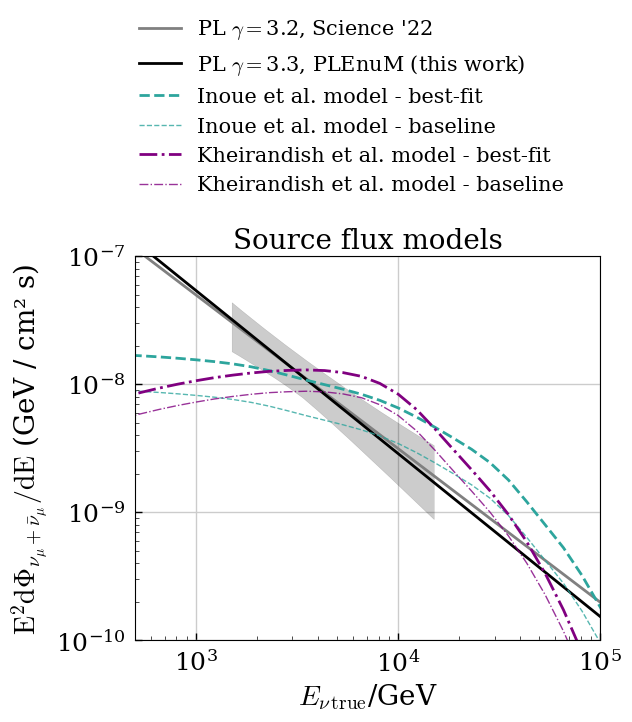

In [71]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_flux.E0, out_global_plc[0][2], ngc_flux.norm * out_global_plc[0][1]
) * cut_off(x_evals, 10 ** out_global_plc[0][3])

f, ax = plt.subplots(figsize=(6, 6))
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

ax.set_yscale("log")
ax.set_ylabel(
    r"$\rm E^2 d\Phi_{\nu_\mu + \bar{\nu}_\mu} / dE$ (GeV / cm² s)", fontsize=fontsize
)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 0.1e-6)
ax.set_xlim(5e2, 1e5)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, st.E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)
# science paper result
ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${st.GAMMA_NGC}, Science '22",
    color="gray",
    alpha=1,
    lw=2,
)
# our fit (no butterfly)
ax.plot(
    x_evals,
    power_law(x_evals, ngc_flux.E0, out_global_pl[0][2], ngc_flux.norm * out_global_pl[0][1])
    * (x_evals**y_scaling),
    label=rf"PL $\gamma=${out_global_pl[0][2]:1.1f}, PLEnuM (this work)",
    color="k",
    alpha=1,
    lw=2,
)


# inoue model and best-fit
ax.plot(
    x_evals,
    (10 ** inoue_src_flux.model_spline(np.log10(x_evals)))
    * out_inoue_only[0][1]
    * (x_evals**y_scaling),
    label="Inoue et al. model - best-fit",
    color=st.colors[1],
    ls="--",
)

ax.plot(
    x_evals,
    (10 ** inoue_src_flux.model_spline(np.log10(x_evals)))
    * (x_evals**y_scaling),
    label="Inoue et al. model - baseline",
    color=st.colors[1], lw=1, alpha=0.8,
    ls="--",
)
# kheirandish model and best-fit
ax.plot(
    x_evals,
    (10 ** kheirandish_src_flux.model_spline(np.log10(x_evals)))
    * out_kheirandish_only[0][1]
    * (x_evals**y_scaling),
    color="purple",
    ls="-.",
    label="Kheirandish et al. model - best-fit",
)
ax.plot(
    x_evals,
    (10 ** kheirandish_src_flux.model_spline(np.log10(x_evals)))
    * (x_evals**y_scaling),
    color="purple", lw=1, alpha=0.8,
    ls="-.",
    label="Kheirandish et al. model - baseline",
)
ax.tick_params(direction="in", which="minor", length=3)
ax.tick_params(direction="in", which="major", length=5)
f.legend(frameon=False, loc="center left", bbox_to_anchor=(0.1, 1), fontsize=15)
f.subplots_adjust(top=0.75) #815)
